In [1]:
%matplotlib qt

In [2]:
import matplotlib as mpl
import sys
sys.path.append("/Users/yao/Smilei")
import happi
import numpy as np
import matplotlib.pyplot as plt

jetcmap = plt.cm.get_cmap("jet", 9) #generate a jet map with 10 values "rainbow", "jet", YlOrRd
jet_vals = jetcmap(np.arange(9)) #extract those values as an array 
jet_vals[0] = [1.0, 1, 1.0, 1] #change the first value 
jet_vals[8] = [0.0, 0, 0.0, 1] #change the first value 
newcmap = mpl.colors.LinearSegmentedColormap.from_list("mine", jet_vals) 

from matplotlib import font_manager

font_dirs = ['/Users/yao/Documents/Calibri and Cambria Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Calibri'

plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=14)
plt.rc('legend', fontsize=12)

/var/folders/2t/97rc3fl92tg15k2l_4sk5hsh0000gn/T/ipykernel_89393/621321092.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jetcmap = plt.cm.get_cmap("jet", 9) #generate a jet map with 10 values "rainbow", "jet", YlOrRd


In [15]:
## prepare simulation data

wkdir = [
    #  '/Users/yao/Documents/Data/IFE/test0/laser_propagation_3d', # with only test particles
    #  '/Users/yao/Documents/Data/IFE/test0/laser_propagation_3d_target/', # with a thin foil target
    #  '/Users/yao/Desktop/test1/',
    #  '/Users/yao/Desktop/IFE_FlatTop_3D/',
    #  '/Users/yao/Desktop/ife_yao0/',
    #  '/Users/yao/Desktop/data/ife_yao2_cp2/',
    #  '/Users/yao/Desktop/data/ife_yao2_cp3/',
    #  '/Users/yao/Desktop/ife_yao3/',
    #  '/Users/yao/Documents/Data/IFE/ife_yao1_Ly25.6/',
    '/Users/yao/Documents/Data/IFE/ife_yao3_Ly51.2/',
     '/Users/yao/Desktop/ife_yao4/',
    ]

S0 = happi.Open(wkdir[0], reference_angular_frequency_SI = 2.0*np.pi*3e8/(1.0*1e-6))
S1 = happi.Open(wkdir[1], reference_angular_frequency_SI = 2.0*np.pi*3e8/(1.0*1e-6))


18790481920.0
Loaded simulation '/Users/yao/Documents/Data/IFE/ife_yao3_Ly51.2/'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics
Scanning for new particle diagnostics
18790481920.0
Loaded simulation '/Users/yao/Desktop/ife_yao4/'
Scanning for Scalar diagnostics
Scanning for Field diagnostics
Scanning for Probe diagnostics
Scanning for ParticleBinning diagnostics
Scanning for RadiationSpectrum diagnostics
Scanning for Performance diagnostics
Scanning for Screen diagnostics
Scanning for Tracked particle diagnostics
Scanning for new particle diagnostics


In [16]:
Lx = S0.namelist.Lx / 2 / np.pi      # in um
print("Lx = ", Lx)
Ly = S0.namelist.Ly / 2 / np.pi      # in um
print("Ly = ", Ly)
Lz = S0.namelist.Lz / 2 / np.pi      # in um
print("Lz = ", Lz)

Lx =  80.0
Ly =  51.2
Lz =  51.2


In [9]:
Bxm0 = S0.Field(0,"Bx_m",subset={'z':Lz/2.},
         units=['um','fs','T'],
         vsym=True,
         cmap='smileiD',
         aspect='equal',
         )
# Bxm.set(layout='tight')
Bxm1 = S1.Field(0,"Bx_m",subset={'z':Lz/2.},
         units=['um','fs','T'],
         vsym=True,
         cmap='smileiD',
         aspect='equal',
         )

happi.multiSlide(Bxm0, Bxm1,shape=(2,1))

In [17]:
def fft_field_analysis(S, diag_num, field_name, slice_direction, slice_position, timestep, k_filter_x, k_filter_y):
    """
    Perform FFT analysis on a given field from the simulation data.
    
    Parameters:
    S : happi.Simulation
        The simulation object.
    diag_num : int
        The diagnostic number of the field.
    field_name : str
        The name of the field to analyze.
    slice_direction : str
        e.g., 'x', 'y', 'z', etc.
    slice_position : float
        The position to slice the field (e.g., Lz/2).
    timestep : int
        The timestep at which to perform the analysis.
    k_filter_x, k_filter_y : float
        The mask to filter out the signals. Laser is 1.
    
    Returns:
    kx : np.ndarray
        The wave numbers in the x-direction.
    ky : np.ndarray
        The wave numbers in the y-direction.
    spectrum : np.ndarray
        The FFT spectrum of the field.
    """
    field = S.Probe(diag_num, field_name, subset={slice_direction:slice_position},
                    units=['um','fs','T'],
                    vsym=True)
    
    data = np.array(field.getData()[timestep])
    field_x = np.array(field.getAxis('axis1'))
    field_y = np.array(field.getAxis('axis2'))
    Nx = data.shape[0]
    Ny = data.shape[1]
    dx = (field_x[1] - field_x[0])[0]
    dy = (field_y[1] - field_y[0])[1]
    kx = np.fft.fftfreq(Nx, d=dx) * 2 * np.pi #spatial freq extents
    ky = np.fft.fftfreq(Ny, d=dy) * 2 * np.pi
    KX, KY = np.meshgrid(kx, ky, indexing='ij')

    pwr=12 #super gaussian power
    # k_filter_x = 0.8
    # k_filter_y = 15
    mask = np.exp(- np.sqrt((KX / k_filter_x)**2 + (KY / k_filter_y)**2)**pwr)

    data_fft  = np.fft.fft2(data, axes=(0,1))   # shape (Nx, Ny)
    Diag_data = np.real(np.fft.ifft2(data_fft* mask[:,:]))
    
    return kx, ky, data, Diag_data


In [18]:
kx0, ky0, Bx0, Bx0_masked = fft_field_analysis(S0, 0, "Bx", 'z', Lz/2., -1, 0.7, 15)
kx1, ky1, Bx1, Bx1_masked = fft_field_analysis(S1, 0, "Bx", 'z', Lz/2., -1, 0.7, 15)

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(Bx0_masked.T,
               origin='lower',
               extent=[0, Lx, 0, Ly],
               vmin=-5000, vmax=5000,
               aspect='equal',
               cmap='bwr')

# Make a colorbar axis that exactly matches the height of `ax`
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # width & gap
cb = fig.colorbar(im, cax=cax)

ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')

plt.tight_layout()

In [5]:
import scienceplots as splt
plt.style.use(['nature', 'notebook', 'grid','high-vis'])


In [ ]:

cell_y = 30 # 1 cell = 0.04 um along y
center = int(Bx0_masked.shape[1] / 2)
xx = np.linspace(0, Lx, Bx0_masked.shape[0])
yy = np.linspace(0, Ly, Bx0_masked.shape[1])
plt.plot(xx, np.average(Bx0_masked[:,(center-cell_y):(center+cell_y)], axis=1), label='low-reso', color='blue', linestyle='-')
cell_y = 60 # 1 cell = 0.04 um along y
center = int(Bx1_masked.shape[1] / 2)
xx = np.linspace(0, Lx, Bx1_masked.shape[0])
yy = np.linspace(0, Ly, Bx1_masked.shape[1])
plt.plot(xx, np.average(Bx1_masked[:,(center-cell_y):(center+cell_y)], axis=1), label='high-reso', color='red', linestyle='--')
plt.xlabel('x (um)')
plt.ylabel('Bx (T)')
plt.title('Averaged Bx field at y = {:.1f} um with a width of {:.1f} um'.format(yy[center], 2*cell_y*(Ly/Bx1_masked.shape[1])))
plt.grid(alpha=0.3, linestyle=':', which='both')
plt.tight_layout()
plt.xlim(0, Lx)
plt.legend()
# plt.ylim(-5000, 35000)
plt.savefig('/Users/yao/Desktop/Bx_profile_x_benchmark.png', dpi=300)

In [144]:
cell_x = 80 # 1 cell = 0.08 um along x
target_surface = int(Bx0_masked.shape[0] * 0.45) # target is at 0.45 Lx
plt.plot(yy, np.average(Bx0_masked[(target_surface-cell_x):(target_surface+cell_x), :], axis=0))
plt.xlabel('y (um)')
plt.ylabel('Bx (T)')
plt.title('Averaged Bx field at x = {:.1f} um with a width of {:.1f} um'.format(xx[target_surface], 2*cell_x*(Lx/Bx0_masked.shape[0])))
plt.grid(alpha=0.3, linestyle=':', which='both')
plt.tight_layout()
plt.xlim(0, Ly)
# plt.ylim(-5000, 35000)
plt.savefig('/Users/yao/Desktop/Bx_profile_y.png', dpi=300)

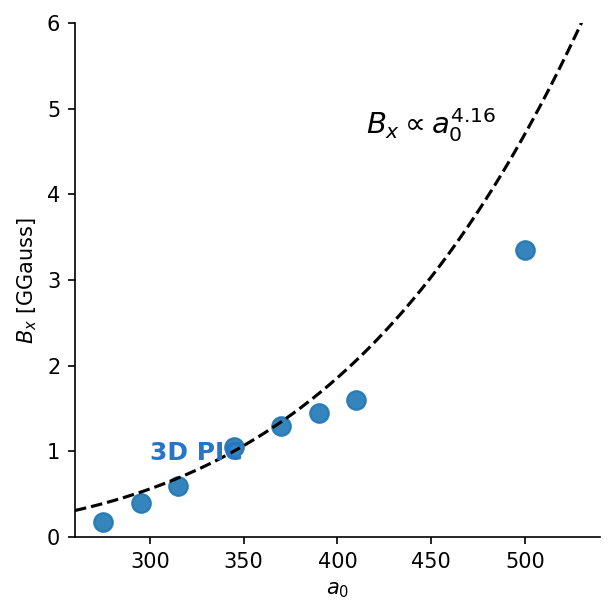

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# --- Example data (edit to your exact values if you have them) ---
a0 = np.array([275, 295, 315, 345, 370, 390, 410, 500])
Bx = np.array([0.18, 0.40, 0.60, 1.05, 1.30, 1.45, 1.60, 3.35])  # in GGauss

# --- Power-law: Bx ∝ a0^4.16 (scaled to pass near the data median) ---
p = 4.16
a_ref = 360.0
Bx_ref = 1.2  # choose a reference point to set the proportionality constant
k = Bx_ref / (a_ref**p)

a_fit = np.linspace(260, 540, 400)
Bx_fit = k * a_fit**p

# --- Plot ---
plt.figure(figsize=(4.2, 4.2), dpi=150)

# Scatter (3D PIC points)
plt.scatter(a0, Bx, s=80, alpha=0.9)

# Power-law dashed curve
plt.plot(a_fit, Bx_fit, 'k--', linewidth=1.5)

# Limits and ticks similar to the example
plt.xlim(260, 540)
plt.ylim(0, 6)

# Labels
plt.xlabel(r'$a_0$')
plt.ylabel(r'$B_x\ \mathrm{[GGauss]}$')

# Annotation "3D PIC"
plt.text(300, 0.9, '3D PIC', color='#2874C5', fontsize=12, weight='bold')

# Annotation for power-law
plt.text(415, 4.7, r'$B_x \propto a_0^{4.16}$', fontsize=14)

# A few cosmetic tweaks
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.tight_layout()

# Save (optional)
# plt.savefig('Bx_vs_a0.png', dpi=300, bbox_inches='tight')

plt.show()

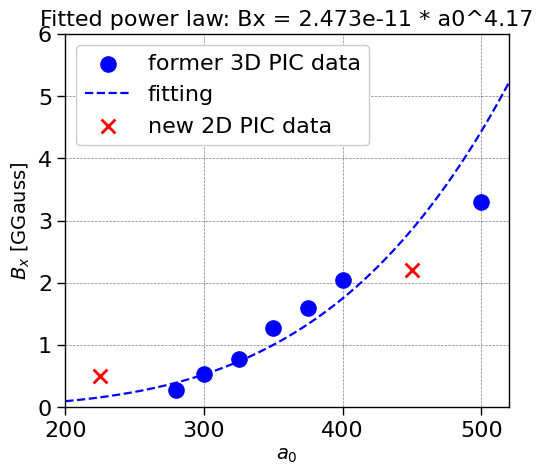

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# ---- Fine-tuned data (from the image) ----
# a0 values (x-axis) and corresponding Bx in GGauss (y-axis)
a0 = np.array([280, 300, 325, 350, 375, 400, 500], dtype=float)
Bx = np.array([0.28, 0.53, 0.78, 1.27, 1.60, 2.05, 3.30], dtype=float)

a1 = np.array([225, 450], dtype=float)
Bx1 = np.array([0.5, 2.2], dtype=float)

# ---- Fit a power law: Bx = C * a0^p ----
log_a0 = np.log(a0)
log_Bx = np.log(Bx)
p, logC = np.polyfit(log_a0, log_Bx, 1)
C = np.exp(logC)

# Smooth curve for the fitted relation
a0_fit = np.linspace(200, 520, 300)
Bx_fit = C * a0_fit**p

# ---- Plot ----
plt.figure(figsize=(5.2, 4.6))
plt.scatter(a0, Bx, s=120, color='b', label='former 3D PIC data')              # default color, similar to the figure
plt.plot(a0_fit, Bx_fit, '--', lw=1.6, color='b', label="fitting")  # dashed fit line
plt.scatter(a1, Bx1, s=100, color='red', marker='x', label='new 2D PIC data')  # new data points

# Axes style to match the original figure
plt.xlabel(r'$a_0$', fontsize=14)
plt.ylabel(r'$B_x$ [GGauss]', fontsize=14)
plt.xlim(200, 520)
plt.ylim(0.0, 6.0)
plt.tight_layout()
plt.legend()
plt.title(f"Fitted power law: Bx = {C:.3e} * a0^{p:.2f}")
plt.show()

# Print the fitted law for reference
# print(f"Fitted power law: Bx = {C:.3e} * a0^{p:.2f}")

In [32]:
S0.ParticleBinning(0,units=['um','fs','T','V/m','cm^-3'],
                   aspect='equal',
                #    data_log=True,
                   cmap='smileiD',
                   vsym=True,
                #    vmin=19,
                #    vmax=23,
                #    subset={'z':S0.namelist.Ltrans/2.},
                #    subset={'x':S0.namelist.Ltrans/2.},
                   ).slide()    


#0 - user_function of species # 1
    y from 0 to 160.85 in 128 steps 
    z from 0 to 160.85 in 128 steps 

The value in each bin is the sum of the `deposited_quantity` divided by the bin size and by grid_length[0]



In [33]:
S0.ParticleBinning(1,units=['um','fs','T','V/m','cm^-3'],
                   aspect='equal',
                #    data_log=True,
                   cmap='smileiD',
                   vsym=True,
                #    vmin=19,
                #    vmax=23,
                #    subset={'z':S0.namelist.Ltrans/2.},
                #    subset={'x':S0.namelist.Ltrans/2.},
                   ).slide()    


#1 - user_function of species # 0
    y from 0 to 160.85 in 128 steps 
    z from 0 to 160.85 in 128 steps 

The value in each bin is the sum of the `deposited_quantity` divided by the bin size and by grid_length[0]



In [34]:
S0.ParticleBinning(2,units=['um','fs','T','V/m','cm^-3'],
                   aspect='equal',
                #    data_log=True,
                   cmap='smileiD',
                   vsym=True,
                #    vmin=19,
                #    vmax=23,
                #    subset={'z':S0.namelist.Ltrans/2.},
                #    subset={'x':S0.namelist.Ltrans/2.},
                   ).slide()    


#2 - user_function of species # 2
    y from 0 to 160.85 in 128 steps 
    z from 0 to 160.85 in 128 steps 

The value in each bin is the sum of the `deposited_quantity` divided by the bin size and by grid_length[0]



In [43]:
S0.ParticleBinning(3,units=['um','fs','T','V/m','cm^-3'],
                   aspect='equal',
                   data_log=True,
                   cmap=newcmap,
                #    vsym=True,
                   vmin=20,
                   vmax=24,
                   subset={'z':S0.namelist.Lz/2.},
                #    subset={'x':S0.namelist.Ltrans/2.},
                   ).slide()  


#3 - Number density of species # 1
    x from 0 to 502.655 in 1000 steps 
    y from 0 to 160.85 in 620 steps 
    z from 79.7965 to 81.0531 in 3 steps 

subset at z = [80.4248] L_r
The value in each bin is the sum of the `deposited_quantity` divided by the bin size



/Users/yao/Smilei/happi/_Diagnostics/Diagnostic.py:857: RuntimeWarning: divide by zero encountered in log10
  return self._np.log10( self._dataLinAtTime(t) )


In [35]:
S1.Field(0,"Ez",
               subset={'z':Lz},
               # average={'z':Lz/2.},
         units=['um','fs','V/m'],
         vsym=True,
         cmap='smileiD',
         aspect='equal',
         ).slide()

Field diagnostic #0: Ez
	Grid spacing: 1.2566370614359172, 1.2566370614359172, 1.2566370614359172
	subset at z = [25.13274123] L_r


In [45]:
Ey0 = S0.Probe(0,"Bx",
               subset={'z':Lz/2.},
               # average={'z':Lz/2.},
         units=['um','fs','V/m','T'],
         vsym=True,
         cmap='smileiD',
         aspect='equal',
         ).slide()

# Ey1 = S1.Probe(0,"Ey",
#                subset={'z':Lz},
#                # average={'z':Lz/2.},
#          units=['um','fs','V/m','T'],
#          vsym=True,
#          cmap='smileiD',
#          aspect='auto',
#          )#.slide()

# happi.multiSlide(Ey0, Ey1,shape=(2,1))

Probe #0: 2-dimensional, with fields Bx,Jy,Jz,Jx
	p0 = 0.0 0.0 80.4247719318987
	p1 = 502.6548245743669 0.0 80.4247719318987
	p2 = 0.0 160.8495438637974 80.4247719318987
	number = 1000 620


In [57]:
data = np.array(S0.Probe(0,"Bx",subset={'z':Lz/2.}).getData()[-1])

In [58]:
data.shape

(1000, 620)

In [66]:
data_x = S0.Probe(0,"Bx",subset={'z':Lz/2.}).getAxis('axis1')
data_y = S0.Probe(0,"Bx",subset={'z':Lz/2.}).getAxis('axis2')


In [65]:
(data_x[1] - data_x[0])[0]

0.5031579825569238

In [69]:
(data_y[1] - data_y[0])[1]

0.2598538673082349